最近在看爱建证券的多因子模型梳理，好多地方不是特别明白，这里对这篇研报里面CAPM模型进行简单探索，加深理解之作。

## 2.4.1 资本资产定价模型

$E(r_i) - r_s = \alpha_i +  \beta_i*E(r_m-r_s)$

$E(r_t)$预期的组合收益，$r_s$为无风险收益率，$r_m$为基准收益。

在资本资产定价模型下：任何股票的超额收益仅与$\beta$相关，即预期超额收益率与$\beta$成正比。$\beta$为先验概念，值由线性回归定义：

$r_p(t) = \alpha_p + \beta_p r_m(t)+\epsilon_p(t)$

$r_p(t)$表示股票或者组合的超额收益，$r_m(t)$时刻$t$市场的超额收益。对历史数据回归得到的$\alpha,\beta$称为历史$\alpha,\beta$值。

$\beta$将任意的组合收益分解为两个不相关的部分，市场收益和残差收益。

股票受到自身特性的影响和市场因素(市场-系统性风险)的影响。

这里对CAPM的定价公式做一个简单的展开  
$r_p(t) = \alpha_p + \beta_p r_m(t)+\epsilon_p(t)$
$r_p(t)$平安银行收益率
$r_m(t)$ HS300指数相对于无风险利率的超额收益率

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import linear_model
# from CAL.PyCAL import font
# sns.set_style('white')

import seaborn as sns
from scipy.optimize import minimize

pd.set_option('display.max_columns', None)  # 最多所有列
pd.set_option('display.max_rows', None)  # 显示所有行
# pd.set_option('display.float_format',lambda x: '%.6f'%x) # #显示小数位数两位
pd.set_option('display.width', 1024)  # 显示宽度
# pd.set_option('precision', 1)   # 设置显示数值的精度

import warnings
warnings.filterwarnings('ignore')  # 关闭运行时的警告
np.set_printoptions(linewidth=100, suppress=True)   # 打印numpy时设置显示宽度，并且不用科学计数法显示
print('载入完成')

#无风险收益率
#取13国债 13国债01
s = 3.15/100
#交易日设定为260
#每日无风险利率为
r_s = np.power((1.+s), (1./260))- 1.
print(r_s)

载入完成
0.00011929193598314569


In [2]:
#基准收益率设置为HS300指数日间收益率
r_m = DataSource('bar1d_CN_FUND').read('510330.HOF',start_date='2019-01-01',end_date='20210801')
#基准相对于无风险利率的超额收益率为
r_m['alpha'] = r_m['close'].pct_change() - r_s
r_m[1:].head()

,turn,instrument,volume,paused,open,adjust_factor,close,high,amount,low_limit,date,high_limit,low,alpha
1,0.010767,510330.HOF,81599081.0,NaN,2.968,1.138594,2.964,3.006,242821590.0,2.671,2019-01-03,3.265,2.958,-0.001467
2,0.017791,510330.HOF,135195494.0,NaN,2.950,1.138594,3.041,3.041,404612973.0,2.668,2019-01-04,3.260,2.937,0.025859
3,0.015923,510330.HOF,120939999.0,NaN,3.045,1.138594,3.050,3.062,368706822.0,2.737,2019-01-07,3.345,3.036,0.002840
4,0.008539,510330.HOF,64808653.0,NaN,3.050,1.138594,3.051,3.055,197509623.0,2.745,2019-01-08,3.355,3.038,0.000209
5,0.021808,510330.HOF,167463997.0,NaN,3.053,1.138594,3.073,3.122,518640473.0,2.746,2019-01-09,3.356,3.053,0.007091


In [3]:
# 取个股
tmp = DataSource('bar1d_CN_FUND').read('512690.HOF',start_date='2019-01-01',end_date='20210801', fields=['date', 'close'])
# tmp[pd.to_datetime(tmp['date']) <= pd.to_datetime('2021-05-14')]['close'] = tmp[pd.to_datetime(tmp['date']) <= pd.to_datetime('2021-05-14')]['close'] / 1.961
tmp.iloc[:494, 2] = tmp.iloc[:494, 2] / 1.961
# tmp.loc[:'2021-05-14', 'close'] = tmp.loc[:'2021-05-14', 'close'] / 1.961
tmp['return'] = tmp['close'].pct_change()
tmp = tmp[1:]
tmp.reset_index(drop=True,inplace= True)

r_m = r_m[pd.to_datetime(r_m['date']) >= pd.to_datetime(tmp.loc[0, 'date'])]
r_m.reset_index(drop=True,inplace= True)
tmp.tail(6)

,instrument,date,close,return
541,512690.HOF,2021-07-23,1.353,-0.024513
542,512690.HOF,2021-07-26,1.252,-0.074649
543,512690.HOF,2021-07-27,1.198,-0.043131
544,512690.HOF,2021-07-28,1.216,0.015025
545,512690.HOF,2021-07-29,1.201,-0.012336
546,512690.HOF,2021-07-30,1.125,-0.063281


In [11]:
r_m.head()

,turn,instrument,volume,paused,open,adjust_factor,close,high,amount,low_limit,date,high_limit,low,alpha
0,0.090370,510330.HOF,612499144.0,NaN,3.683,1.138594,3.712,3.736,2.272604e+09,3.312,2019-05-07,4.048,3.670,0.008576
1,0.019441,510330.HOF,132652006.0,NaN,3.651,1.138594,3.662,3.723,4.880890e+08,3.341,2019-05-08,4.083,3.642,-0.013589
2,0.022929,510330.HOF,158294213.0,NaN,3.644,1.138594,3.600,3.657,5.721441e+08,3.296,2019-05-09,4.028,3.573,-0.017050
3,0.032226,510330.HOF,226005681.0,NaN,3.623,1.138594,3.718,3.733,8.282491e+08,3.240,2019-05-10,3.960,3.576,0.032658
4,0.013914,510330.HOF,97591565.0,NaN,3.670,1.138594,3.662,3.698,3.588569e+08,3.346,2019-05-13,4.090,3.649,-0.015181


#### 股票和基准的时间序列

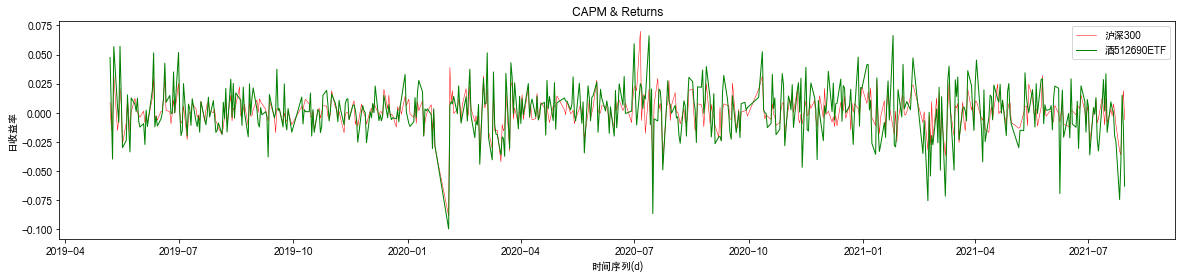

In [66]:
plt.figure(figsize=(20,4))
plt.plot(r_m.date, r_m['alpha'], label="沪深300",color="red",linewidth=.5)
plt.plot(tmp.date, tmp['return'],label="酒512690ETF",color="green",linewidth=1.)
plt.xlabel("时间序列(d)")
plt.ylabel("日收益率")
plt.title("CAPM & Returns")
plt.axis('tight')
plt.legend()
plt.show()

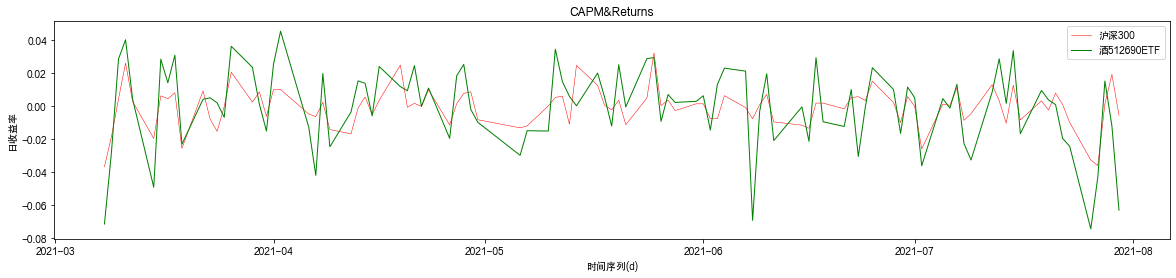

In [4]:
plt.figure(figsize=(20,4))
# plt.plot(r_m.date[:100], r_m.alpha[:100], label="沪深300",color="red",linewidth=.5)
# plt.plot(tmp.date[:100], tmp['return'][:100],label="酒512690ETF",color="green",linewidth=1.)
plt.plot(r_m.date[-100:], r_m.alpha[-100:], label="沪深300",color="red",linewidth=.5)
plt.plot(tmp.date[-100:], tmp['return'][-100:],label="酒512690ETF",color="green",linewidth=1.)
plt.xlabel("时间序列(d)")
plt.ylabel("日收益率")
plt.title("CAPM&Returns")
plt.axis('tight')
plt.legend()
plt.show()

大体上看这个时间序列相关性很高。

这里对CAPM的定价公式做一个简单的展开  
$r_p(t) = \alpha_p + \beta_p r_m(t)+\epsilon_p(t)$
$r_p(t)$平安银行收益率
$r_m(t)$ HS300指数相对于无风险利率的超额收益率
使用线性回归利用历史数据估计$\beta$和$\alpha+\epsilon$

In [10]:
rm = r_m['alpha'].values
rp = tmp['return'].values
beta, alpha, rvalue, pvalue, stderr = stats.linregress(rm, rp)
print(beta,'---',alpha)

1.1085113196019991 --- 0.0004112192430326861


查看拟合值与真实值的情况
$r_e = \beta *r_m +\alpha$

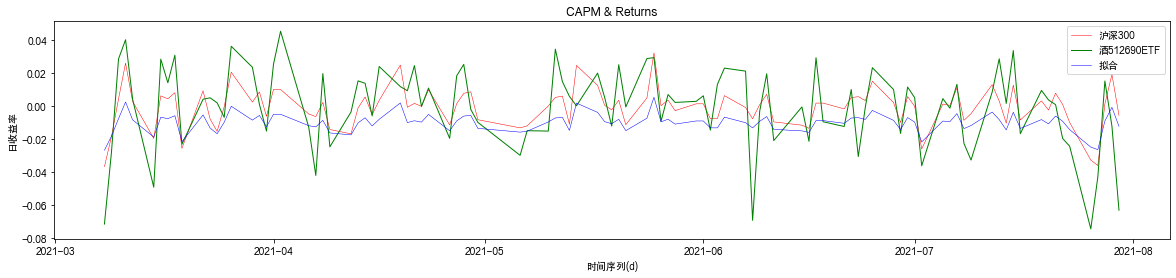

In [68]:
re = rm*beta + alpha 
plt.figure(figsize=(20,4))
plt.plot(r_m.date[-100:], r_m['alpha'][-100:], label="沪深300",color="red",linewidth=.5)
plt.plot(tmp.date[-100:], tmp['return'][-100:],label="酒512690ETF",color="green",linewidth=1.)
plt.plot(tmp.date[-100:], re[-100:], label="拟合",color="blue",linewidth=.5)
plt.xlabel("时间序列(d)")
plt.ylabel("日收益率")
plt.title("CAPM & Returns")

plt.axis('tight')
plt.legend()
plt.show()

上面的使用数年的数据进行拟合,下面使用一个简单的线型模型对数据进行滚动区段拟合

In [30]:
lrm = r_m['alpha'].values
lrp = tmp['return'].values
date = tmp['date'].values
ltmp = pd.DataFrame({'rm': lrm, 'rp': lrp, 'date': date})
# print(ltmp.iloc[65-60:65, :2].head())
# 进行区段滚动拟合
list_date = []
list_alpha = []
list_beta = []
list_p = []
list_stderr = []
for i in ltmp.index[60:]:
    temp = np.array(ltmp.iloc[i-60:i, :2])
    beta, alpha, rvalue, pvalue, stderr = stats.linregress(temp)
    list_alpha.append(alpha)
    list_beta.append(beta)
    list_p.append(pvalue)
    list_stderr.append(stderr)
    list_date.append(ltmp.iloc[i, 2])
    
tp = pd.DataFrame([list_alpha, list_beta, list_p, list_stderr, list_date], index=['alpha','beta', 'p', 'stderr', 'date']).T
tp.mean()#.head()

alpha     0.001741
beta      1.124819
p         0.000014
stderr    0.157976
dtype: float64

In [31]:
r_m_t = r_m[['date', 'alpha']].copy()
r_m_t.rename(columns={'alpha':'s_rm'}, inplace=True)
# r_m_t.head()
tp = tp.merge(r_m_t, on='date', how='left')
tp['re'] = tp['s_rm'] * tp['beta'] + tp['alpha']
tp.head()

,alpha,beta,p,stderr,date,s_rm,re
0,0.001224,1.560167,0.0,0.124618,2019-07-31,-0.007244,-0.010078
1,0.000583,1.535626,0.0,0.115251,2019-08-01,-0.009602,-0.014161
2,0.000156,1.577198,0.0,0.111028,2019-08-02,-0.013315,-0.020844
3,0.000623,1.525828,0.0,0.111301,2019-08-05,-0.018735,-0.027963
4,0.000675,1.473157,0.0,0.11655,2019-08-06,-0.012142,-0.017211


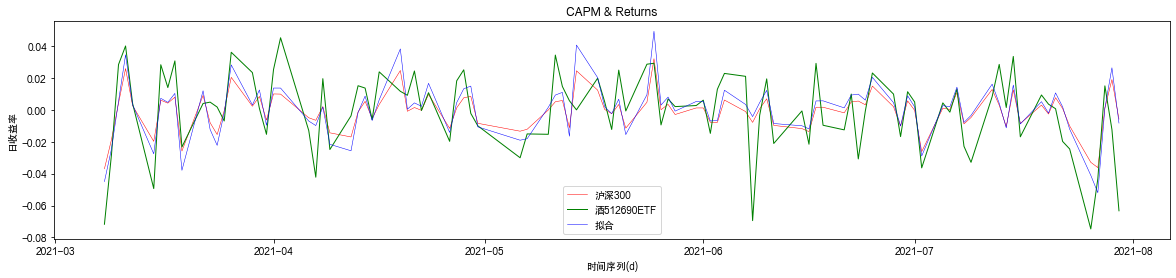

In [32]:
plt.figure(figsize=(20,4))
plt.plot(r_m.date[-100:], r_m['alpha'][-100:], label="沪深300",color="red",linewidth=.5)
plt.plot(tmp.date[-100:], tmp['return'][-100:],label="酒512690ETF",color="green",linewidth=1.)
plt.plot(tp.date[-100:], tp['re'][-100:], label="拟合",color="blue",linewidth=.5)
plt.xlabel("时间序列(d)")
plt.ylabel("日收益率")
plt.title("CAPM & Returns")

plt.axis('tight')
plt.legend()
plt.show()

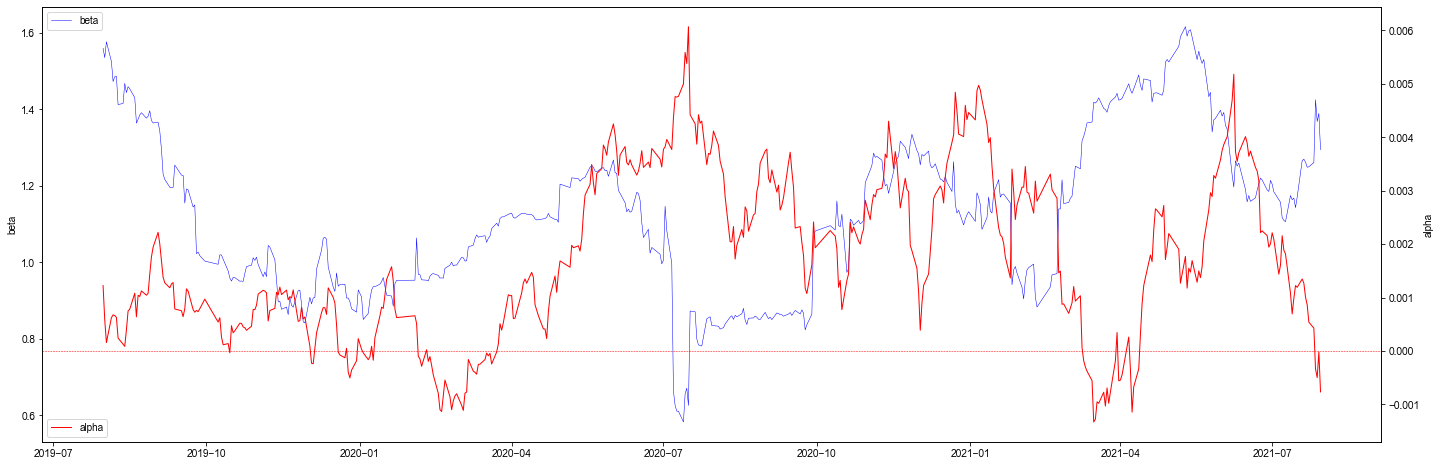

In [71]:
fig, ax1 = plt.subplots(figsize=(24,8))
plt.plot(tp.date, tp.beta, label="beta",color="blue",linewidth=.5)
plt.ylabel("beta")
plt.legend(loc='upper left')
ax2 = ax1.twinx()
plt.plot(tp.date, tp.alpha, label="alpha",color="red",linewidth=1.)
plt.axhline(linewidth=.5,linestyle='--', color='r')
plt.ylabel("alpha")
plt.legend(loc='lower left')
# plt.axis('tight')
plt.show()

可以看到线性回归模型中偏置在0分界线附近震荡，从长周期看。强行假设成一个震荡波，设置HS300为基准，则个股出现回归基准线的趋势。
假想$\alpha <0$ 个股相对基准低估 $\alpha >0$个股相对基准高估，做多低估，做空高估。

#### 夏普发现单个股票或者股票组合的预期回报率(Expected Return)的公式如下：
$E(r_t)  = \beta_i*E(r_m-r_s) + r_s$

$E(r_t)$预期的组合收益，$r_s$为无风险收益率，$r_m$为基准收益。
- 注意上面的公式没有偏置的存在   

#### 回归偏置在长时间内正负波动，简单来看就是两个时间序列的关系，假设均值回归，则通过alpha发现偏离程度，做多低估，做空高估然后等待均值回归   
#### 如果将偏置$\alpha$波动情况强行假设为一个损耗震荡波，则alpha偏离均值的程度越大越有可能出现方向反转，也就是做多$-\alpha$做空$+\alpha$
#### 我大A股不能做空下面简单做多回测这个想法。

一般选择的股票组合应该为指数的成份股，这里取得HS300 10%的股票进行持仓，因为简单验证不进行仓位和权重设置。

In [72]:
def rebalance(account, buylist):
    for stock in account.security_position:
        if stock not in buylist:
            order_to(stock, 0)
    
    for stock in buylist:
        order(stock, account.reference_portfolio_value / len(buylist) / account.reference_price[stock])

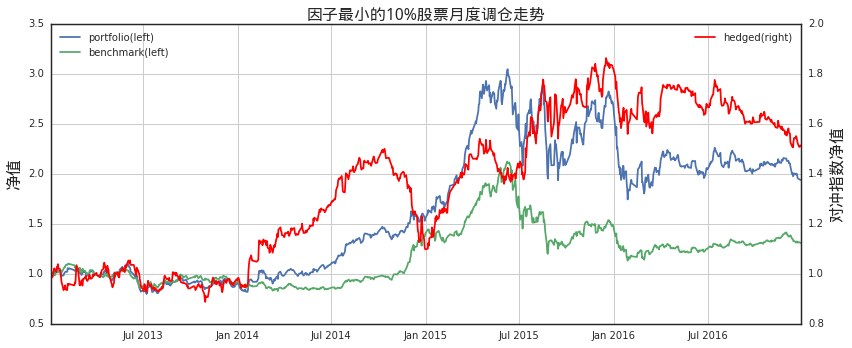

In [ ]:
fig = plt.figure(figsize=(12,5))
fig.set_tight_layout(True)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.grid()

bt_quantile_ten = bt
data = bt_quantile_ten[[u'tradeDate',u'portfolio_value',u'benchmark_return']]
data['portfolio_return'] = data.portfolio_value/data.portfolio_value.shift(1) - 1.0
data['portfolio_return'].ix[0] = data['portfolio_value'].ix[0]/	10000000.0 - 1.0
data['excess_return'] = data.portfolio_return - data.benchmark_return
data['excess'] = data.excess_return + 1.0
data['excess'] = data.excess.cumprod()
data['portfolio'] = data.portfolio_return + 1.0
data['portfolio'] = data.portfolio.cumprod()
data['benchmark'] = data.benchmark_return + 1.0
data['benchmark'] = data.benchmark.cumprod()
# ax.plot(data[['portfolio','benchmark','excess']], label=str(qt))
ax1.plot(data['tradeDate'], data[['portfolio']], label='portfolio(left)')
ax1.plot(data['tradeDate'], data[['benchmark']], label='benchmark(left)')
ax2.plot(data['tradeDate'], data[['excess']], label='hedged(right)', color='r')

ax1.legend(loc=2)
ax2.legend(loc=0)
# ax2.set_ylim(bottom=0.5, top=2.5)
ax1.set_ylabel(u"净值", fontproperties=font, fontsize=16)
ax2.set_ylabel(u"对冲指数净值", fontproperties=font, fontsize=16)
ax2.set_ylabel(u"对冲指数净值", fontproperties=font, fontsize=16)
ax1.set_title(u"因子最小的10%股票月度调仓走势", fontproperties=font, fontsize=16)

Win rate is 49.0216271885%

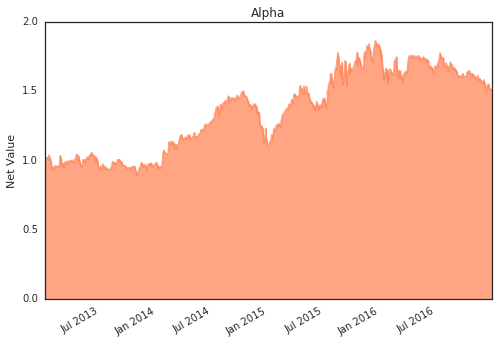

In [ ]:
plot_pure_alpha(bt, 10000000)

In [ ]:
bt_quantile_ten = bt
longdata = bt_quantile_ten[[u'tradeDate',u'portfolio_value',u'benchmark_return','cash']]
longdata['long'] = (longdata.portfolio_value + longdata.cash)/10000000.
longdata['benchmark'] = longdata.benchmark_return + 1.
longdata['benchmark'] = longdata.benchmark.cumprod()
longdata.head()

,tradeDate,portfolio_value,benchmark_return,cash,long,benchmark
0,2013-01-04,9.837088e+06,0.000575,359.0487,0.983745,1.000575
1,2013-01-07,9.934779e+06,0.004587,46.3588,0.993483,1.005165
2,2013-01-08,1.008883e+07,-0.004200,10.7498,1.008884,1.000943
3,2013-01-09,1.016524e+07,0.000313,121.2614,1.016537,1.001256
4,2013-01-10,1.025094e+07,0.001758,110.0496,1.025105,1.003016


### 或者认为这是一个马太效应，多着愈多，做多最多alpha。

[《新约·马太福音》中有这样一个故事。一个国王远行前，交给三个仆人每人一锭银子，吩咐他们：“你们去做生意，等我回来时，再来见我。”国王回来时，第一个仆人说：“主人，你交给我的一锭银子，我已赚了10锭。”于是国王奖励了他10座城邑。第二个仆人报告说：“主人，你给我的一锭银子，我已赚了5锭。”于是国王便奖励了他5座城邑。第三个仆人报告说：“主人，你给我的一锭银子，我一直包在手巾里存着，我怕丢失，一直没有拿出来。”于是,国王命令将第三个仆人的那锭银子赏给第一个仆人，并且说：“凡是少的，就连他所有的，也要夺过来。凡是多的，还要给他，叫他多多益善。”](http://wiki.mbalib.com/wiki/%E9%A9%AC%E5%A4%AA%E6%95%88%E5%BA%94)

### 当然这里不是为了检验马太效应，这里通过买入看空股票计算损失，变相计算多空组合收益率

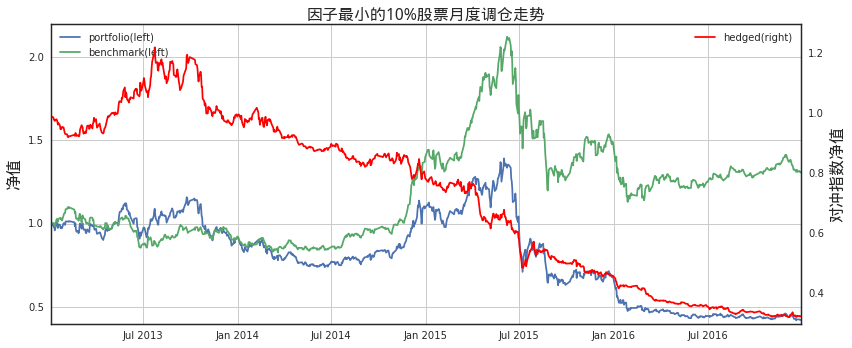

In [ ]:
fig = plt.figure(figsize=(12,5))
fig.set_tight_layout(True)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.grid()

bt_quantile_ten = bt
data = bt_quantile_ten[[u'tradeDate',u'portfolio_value',u'benchmark_return']]
data['portfolio_return'] = data.portfolio_value/data.portfolio_value.shift(1) - 1.0
data['portfolio_return'].ix[0] = data['portfolio_value'].ix[0]/	10000000.0 - 1.0
data['excess_return'] = data.portfolio_return - data.benchmark_return
data['excess'] = data.excess_return + 1.0
data['excess'] = data.excess.cumprod()
data['portfolio'] = data.portfolio_return + 1.0
data['portfolio'] = data.portfolio.cumprod()
data['benchmark'] = data.benchmark_return + 1.0
data['benchmark'] = data.benchmark.cumprod()
# ax.plot(data[['portfolio','benchmark','excess']], label=str(qt))
ax1.plot(data['tradeDate'], data[['portfolio']], label='portfolio(left)')
ax1.plot(data['tradeDate'], data[['benchmark']], label='benchmark(left)')
ax2.plot(data['tradeDate'], data[['excess']], label='hedged(right)', color='r')

ax1.legend(loc=2)
ax2.legend(loc=0)
# ax2.set_ylim(bottom=0.5, top=2.5)
ax1.set_ylabel(u"净值", fontproperties=font, fontsize=16)
ax2.set_ylabel(u"对冲指数净值", fontproperties=font, fontsize=16)
ax2.set_ylabel(u"对冲指数净值", fontproperties=font, fontsize=16)
ax1.set_title(u"因子最小的10%股票月度调仓走势", fontproperties=font, fontsize=16)

Win rate is 44.3872296601%

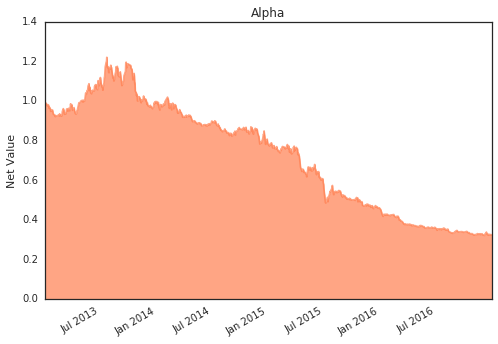

In [ ]:
plot_pure_alpha(bt, 10000000)

In [ ]:
bt_quantile_ten = bt
shortdata = bt_quantile_ten[[u'tradeDate',u'portfolio_value',u'benchmark_return','cash']]
shortdata['short'] = (shortdata.portfolio_value + shortdata.cash)/10000000.
shortdata['benchmark'] = shortdata.benchmark_return + 1.
shortdata['benchmark'] = shortdata.benchmark.cumprod()
shortdata.head()

,tradeDate,portfolio_value,benchmark_return,cash,short,benchmark
0,2013-01-04,9.908261e+06,0.000575,419.7093,0.990868,1.000575
1,2013-01-07,9.946371e+06,0.004587,79.4837,0.994645,1.005165
2,2013-01-08,9.887636e+06,-0.004200,272.4515,0.988791,1.000943
3,2013-01-09,9.820155e+06,0.000313,123.1469,0.982028,1.001256
4,2013-01-10,9.836617e+06,0.001758,3.7221,0.983662,1.003016


### 计算多空组合收益率

In [ ]:
longdata.head()

,tradeDate,portfolio_value,benchmark_return,cash,long,benchmark
0,2013-01-04,9.837088e+06,0.000575,359.0487,0.983745,1.000575
1,2013-01-07,9.934779e+06,0.004587,46.3588,0.993483,1.005165
2,2013-01-08,1.008883e+07,-0.004200,10.7498,1.008884,1.000943
3,2013-01-09,1.016524e+07,0.000313,121.2614,1.016537,1.001256
4,2013-01-10,1.025094e+07,0.001758,110.0496,1.025105,1.003016


In [ ]:
shortdata.head()

,tradeDate,portfolio_value,benchmark_return,cash,short,benchmark
0,2013-01-04,9.908261e+06,0.000575,419.7093,0.990868,1.000575
1,2013-01-07,9.946371e+06,0.004587,79.4837,0.994645,1.005165
2,2013-01-08,9.887636e+06,-0.004200,272.4515,0.988791,1.000943
3,2013-01-09,9.820155e+06,0.000313,123.1469,0.982028,1.001256
4,2013-01-10,9.836617e+06,0.001758,3.7221,0.983662,1.003016


In [ ]:
hedged = longdata[['tradeDate','long','benchmark']]
hedged = pd.concat([hedged, shortdata.short],axis=1)
hedged['hedge'] = (hedged.long - hedged.short)/2.

这里是做多低估做空高估的多空组合净收益率

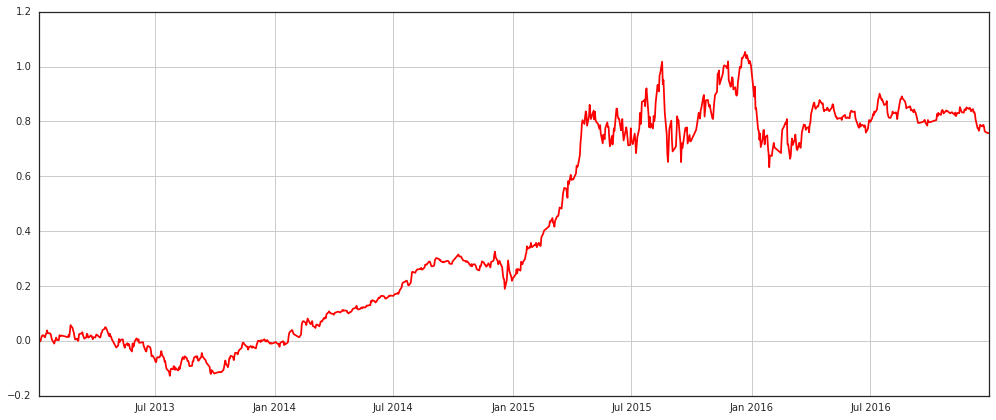

In [ ]:
fig = plt.figure(figsize=(14,6))
fig.set_tight_layout(True)
ax1 = fig.add_subplot(111)
ax1.grid()
ax1.plot(hedged['tradeDate'], hedged['hedge'], label='long',color='r')

将多空组合与HS300股指对冲,得到一个很不稳定的alpha信号。

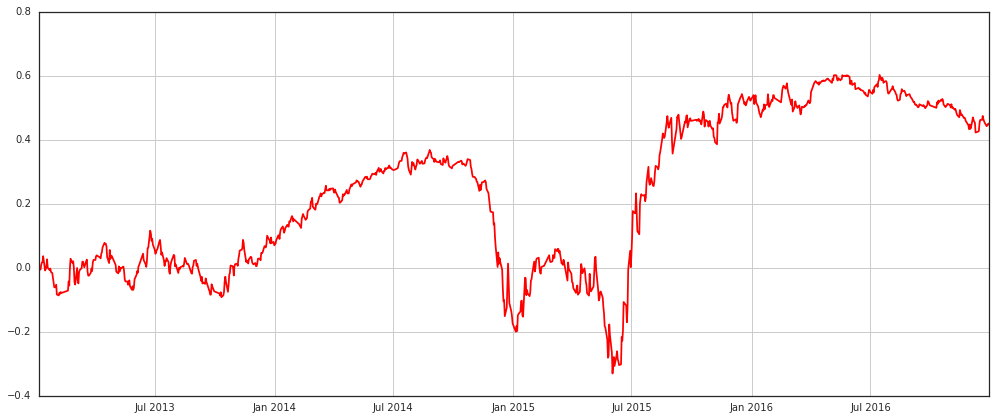

In [ ]:
fig = plt.figure(figsize=(14,6))
fig.set_tight_layout(True)
ax1 = fig.add_subplot(111)
ax1.grid()
ax1.plot(hedged['tradeDate'], (hedged['hedge']+1.-hedged['benchmark']), label='long',color='r')

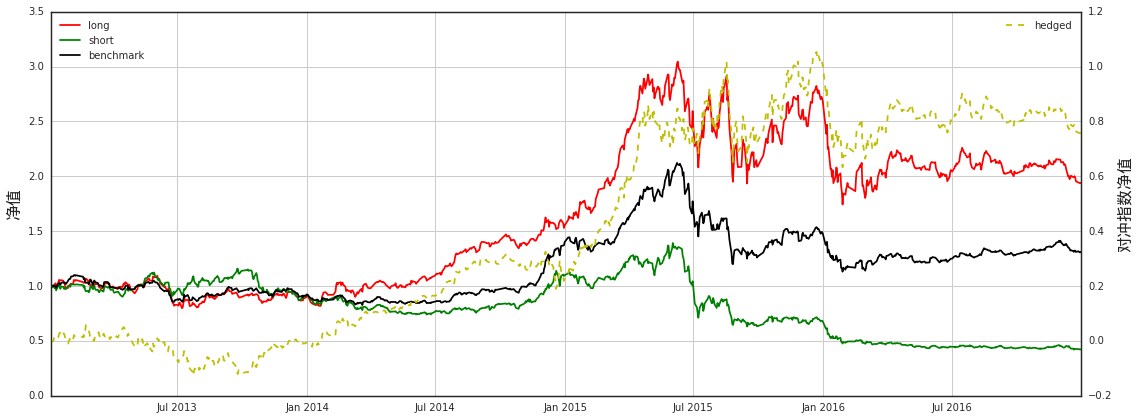

In [ ]:
fig = plt.figure(figsize=(16,6))
fig.set_tight_layout(True)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.grid()
ax1.plot(hedged['tradeDate'], hedged['long'], label='long',color='r')
ax1.plot(hedged['tradeDate'], hedged['short'], label='short',color='g')
ax1.plot(hedged['tradeDate'], hedged['benchmark'], label='benchmark',color='k')
ax1.legend(loc=2)
ax2.plot(hedged['tradeDate'], hedged['hedge'], label='hedged',color='y',linestyle='--')
ax2.legend(loc=0)
ax1.set_ylabel(u"净值", fontproperties=font, fontsize=16)
ax2.set_ylabel(u"对冲指数净值", fontproperties=font, fontsize=16)

引用
爱建证券 多因子系列之一：多因子模型梳理
[高频因子初探-集合竞价成交占比因子](https://uqer.io/community/share/58131804228e5b43f45c2104)